# Multi-Label Classification
## Different Loss Functions to handle Class Imbalances in Long Tailed Data
**Paper Reference:** "Balancing Methods for Multi-label Text Classification with Long-Tailed Class Distribution" (EMNLP 2021)

by Yi Huang, Buse Giledereli, Abdullatif Koksal, Arzucan Ozgur and Elif Ozkirimli.
https://arxiv.org/abs/2109.04712

**Citation:**

@inproceedings{huang2021balancing,
  title={Balancing Methods for Multi-label Text Classification with Long-Tailed Class Distribution},
  author={Huang, Yi and Giledereli, Buse and Koksal, Abdullatif and Ozgur, Arzucan and Ozkirimli, Elif},
  booktitle={Proceedings of the 2021 Conference on Empirical Methods in Natural Language Processing (EMNLP)},
  year={2021}
}

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch
import transformers
from datasets import load_dataset

In [2]:
import os

working_dir = '/kaggle/working/'
files_to_delete = ['utils_get_data.py', 'custom_dataset.py',
                   'custom_loss.py', 'model.py']
# Delete the specified files
for file_name in files_to_delete:
    file_path = os.path.join(working_dir, file_name)
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"{file_name} has been deleted.")
    else:
        print(f"{file_name} not found in working directory.")


!wget https://raw.githubusercontent.com/kamran945/Multi-Label-Text-Classification-DB-Loss/main/utils_get_data.py
!wget https://raw.githubusercontent.com/kamran945/Multi-Label-Text-Classification-DB-Loss/main/custom_dataset.py
!wget https://raw.githubusercontent.com/kamran945/Multi-Label-Text-Classification-DB-Loss/main/custom_loss.py
!wget https://raw.githubusercontent.com/kamran945/Multi-Label-Text-Classification-DB-Loss/main/model.py

from utils_get_data import (download_data, extract_file, 
                            extract_data, create_train_test_split,
                            get_labels)
from custom_dataset import get_train_val_loaders
from custom_loss import CustomLoss
from model import create_model



utils_get_data.py not found in working directory.
custom_dataset.py not found in working directory.
custom_loss.py not found in working directory.
model.py not found in working directory.
--2024-09-08 16:22:34--  https://raw.githubusercontent.com/kamran945/Multi-Label-Text-Classification-DB-Loss/main/utils_get_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9199 (9.0K) [text/plain]
Saving to: 'utils_get_data.py'

utils_get_data.py   100%[===================>]   8.98K  --.-KB/s    in 0.001s  

2024-09-08 16:22:34 (15.0 MB/s) - 'utils_get_data.py' saved [9199/9199]

--2024-09-08 16:22:35--  https://raw.githubusercontent.com/kamran945/Multi-Label-Text-Classification-DB-Loss/main/custom_dataset.py
Resolving raw.githubusercontent.com (raw.githubuserconten

Downloading...
File reuters21578.tar.gz downloaded successfully.
Extracting reuters21578.tar.gz...
File reuters21578.tar.gz extracted successfully to data/reuters21578.
Extracting Data to output file data/reuters21578.json...
Documents with no labels: 10211
Documents with labels: 11367
Total Documents: 21578
Train Documents: 7780
Test Documents: 3022
Total labels: 109
labels: ['acq' 'earn' 'housing' 'money-fx' 'reserves' 'hog' 'livestock' 'trade'
 'iron-steel' 'wool' 'interest' 'grain' 'rice' 'cocoa' 'coffee'
 'money-supply' 'crude' 'nat-gas' 'wheat' 'sugar' 'cotton' 'groundnut'
 'oilseed' 'pet-chem' 'corn' 'pork-belly' 'ipi' 'dlr' 'cpi' 'gnp' 'bop'
 'soybean' 'fuel' 'yen' 'ship' 'alum' 'carcass' 'veg-oil' 'sun-oil' 'wpi'
 'lumber' 'stg' 'saudriyal' 'strategic-metal' 'gold' 'silver' 'copper'
 'zinc' 'lead' 'palm-oil' 'coconut-oil' 'rubber' 'lei' 'jobs' 'rapeseed'
 'tea' 'dfl' 'tin' 'retail' 'gas' 'platinum' 'instal-debt' 'heat' 'orange'
 'inventories' 'meal-feed' 'can' 'income' 'oat' '

/kaggle/working/utils_get_data.py:219: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_labels = pd.unique(all_labels)


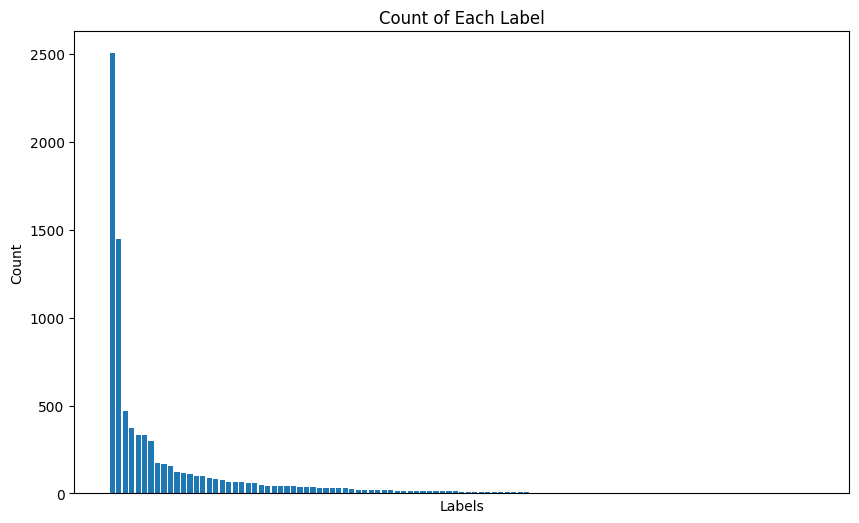

In [3]:
download_data()
extract_file()
df = extract_data()
train_df, val_df, test_df = create_train_test_split(df)
unique_labels, label_counts, label2idx, idx2label = get_labels(train_df)

In [4]:
lables_head = {label: count for label, count in label_counts.items() if count >= 35}
lables_medium = {label: count for label, count in label_counts.items() if ((count < 35) & (count > 8))}
lables_tail = {label: count for label, count in label_counts.items() if count <= 8}
len(lables_head), len(lables_medium), len(lables_tail)

(31, 28, 50)

In [5]:
# Example usage
alpha = 0.5
beta = 0.9999
gamma = 2.0
lambda_ = 0.5
kappa = 1.0

# Create the loss function
loss_fn = CustomLoss(alpha=alpha, gamma=gamma, beta=beta, 
                 lambda_=lambda_, kappa=kappa, num_classes=3, 
                 reduction='mean', loss_type='cb')

# Fake logits (before sigmoid) and targets for a batch of 2 examples, 3 classes
logits = torch.tensor([[1.2, 0.7, -0.5], [0.8, -1.2, 2.3]])
targets = torch.tensor([[1, 0, 1], [0, 1, 0]], dtype=torch.float32)

# Compute the loss
loss = loss_fn(logits, targets)
print(f'Loss: {loss.item()}')

Loss: 0.7139956951141357


In [6]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
# import warnings

# # Suppress specific warning
# warnings.filterwarnings("ignore", message="A parameter name that contains `gamma` will be renamed internally")
# warnings.filterwarnings("ignore", message="A parameter name that contains `beta` will be renamed internally")


# model, tokenizer, optimizer_grouped_parameters = create_model(unique_labels=unique_labels,
#                                                               label2idx=label2idx,
#                                                               idx2label=idx2label)

# initial_params = {name: param.clone() for name, param in model.named_parameters()}

In [8]:
# train_dataloader, val_dataloader = get_train_val_loaders(train_df,
#                                                          val_df,
#                                                          tokenizer,
#                                                          model_config=model.module.config if isinstance(model, torch.nn.DataParallel) else model.config,
#                                                          batch_size=32)

In [27]:

def train(model, criterion, optimizer, 
          train_dataloader, percentage=1.0, 
          device=device, update_interval=50):
    
    total_batches = len(train_dataloader)
    limited_batches = int(percentage * total_batches)
    
    model.train()
    train_steps = 0
    train_loss = 0
    
    for i, batch in enumerate(train_dataloader):

        if i >= limited_batches:
            break
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_steps += 1

        if i % update_interval == 0:
            print(f"Training Step: {i+1}, Data: {round(((i+1)*100/total_batches), 2)}%, Training loss: {train_loss/train_steps}")

    return train_loss/train_steps

def evaluate(model, criterion, 
             val_dataloader, best_th_for_epoch, best_f1_for_epoch, 
             percentage=1.0, device=device, update_interval=10):
    
    total_batches = len(val_dataloader)
    limited_batches = int(percentage * total_batches)
    
    model.eval()
    true_labels, pred_labels, pred_logits = [], [], []
    val_loss = 0
    val_steps = 0
    
    for i, batch in enumerate(val_dataloader):
        if i >= limited_batches:
            break
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.sigmoid(outputs.logits) 

            logits = outputs.logits
            threshold = 0.5
            preds = (preds >= threshold).int()
            loss = criterion(logits, labels)
            val_loss += loss

            val_steps += 1

            pred_labels.append(preds)
            pred_logits.append(logits)
            true_labels.append(labels)  

            if i % update_interval == 0:
                print(f"Validation Step: {val_steps}, Data: {round(((i+1)*100/total_batches), 2)}%, Validation loss: {val_loss/val_steps}")

    print(f"Val loss: {val_loss/val_steps}")
    
    pred_labels = torch.cat(pred_labels)
    pred_logits = torch.cat(pred_logits)
    true_labels = torch.cat(true_labels)
    
    accuracy = accuracy_score(true_labels.cpu().numpy(), pred_labels.cpu().numpy())
    f1 = f1_score(true_labels.cpu().numpy(), pred_labels.cpu().numpy(), average='micro')
    
    f1_score_list = []
    best_f1, best_th = 0, 0
    threshold_values = (np.array(range(-10,11))/100) + 0.5
    
    for th in threshold_values:
        pred_labels_tmp = torch.tensor(np.array([torch.sigmoid(torch.tensor(logits)) for logits in pred_logits.cpu().numpy()]))
        
        pred_labels_tmp = torch.tensor(np.array([(preds >= th).astype(int) for preds in pred_labels_tmp.cpu().numpy()]))
        
        f1 = f1_score(true_labels.cpu().numpy(), pred_labels_tmp.cpu().numpy(), average='micro')
        f1_score_list.append(f1)

    best_f1_idx = np.argmax(f1_score_list)
    best_f1 = f1_score_list[best_f1_idx]
    best_th = threshold_values[best_f1_idx]
    print(f"Previous best: F1: {best_f1_for_epoch}, Th: {best_th_for_epoch}")
    print(f"Current best: F1: {best_f1}, Th: {best_th}")
    if f1_score_list[best_f1_idx] > (best_f1_for_epoch * 0.995):
        best_f1_for_epoch = f1_score_list[best_f1_idx]
        best_th_for_epoch = threshold_values[best_f1_idx]
    return best_f1_for_epoch, best_th_for_epoch

In [ ]:
# alpha = 0.5
# beta = 0.9999
# gamma = 2.0
# lambda_ = 0.5
# kappa = 1.0

# criterion = CustomLoss(alpha=alpha, gamma=gamma, beta=beta, 
#                      lambda_=lambda_, kappa=kappa, num_classes=len(unique_labels), 
#                      reduction='mean', loss_type='cb')


# best_th_for_epoch, best_f1_for_epoch = evaluate(model, criterion, val_dataloader, 
#                                                 best_th_for_epoch=0, best_f1_for_epoch=0, 
#                                                 percentage=0.1, device=device)
# # best_f1, best_th, f1_score_list, pred_logits, pred_labels, true_labels = evaluate(model, criterion, val_dataloader, best_th=0, best_f1=0, percentage=0.1, device=device)

In [28]:
model, tokenizer, optimizer_grouped_parameters = create_model(unique_labels=unique_labels,
                                                                  label2idx=label2idx,
                                                                  idx2label=idx2label)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [29]:
from tqdm import trange
from torch.optim import AdamW

history = {
    'cb': {'loss': [], 'best_f1_micro': [], 'best_th': []},
    'db': {'loss': [], 'best_f1_micro': [], 'best_th': []},
}
loss_keys = ['cb', 'db']

alpha = 0.5
beta = 0.9999
gamma = 2.0
lambda_ = 0.5
kappa = 1.0

max_length = 512
lr = 1e-4
epochs = 30 # in the paper the authors have used 40 epochs, used lesser number here to speed up training
train_percentage = 0.20 # to speed up training (for better results, use all training data)
val_percentage = 0.25


for loss_idx in trange(len(loss_keys)):
    train_dataloader, val_dataloader = get_train_val_loaders(train_df,
                                                             val_df,
                                                             tokenizer,
                                                             model_config=model.module.config if isinstance(model, torch.nn.DataParallel) else model.config,
                                                             batch_size=32)

    criterion = CustomLoss(alpha=alpha, gamma=gamma, beta=beta, 
                           lambda_=lambda_, kappa=kappa, num_classes=len(unique_labels), 
                           reduction='mean', loss_type='cb')
    
    model, tokenizer, optimizer_grouped_parameters = create_model(unique_labels=unique_labels,
                                                                  label2idx=label2idx,
                                                                  idx2label=idx2label)
    optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
    

    best_f1_for_epoch = 0
    best_th_for_epoch = 0
    for epoch in range(epochs):
        loss = train(model, criterion, optimizer, 
                     train_dataloader, 
                     percentage=train_percentage)
        print(f"{loss_keys[loss_idx]}: Epoch {epoch+1}: loss {loss}, Data {train_percentage*100}%")
        history[loss_keys[loss_idx]]['loss'].append(loss)

        best_f1_for_epoch, best_th_for_epoch = evaluate(model, criterion, val_dataloader, 
                                                        best_th_for_epoch, best_f1_for_epoch, 
                                                        percentage=val_percentage)
        print(f"{loss_keys[loss_idx]}: Epoch {epoch+1}: Best F1 (micro) {best_f1_for_epoch}, Best Threshold {best_th_for_epoch}, Data {val_percentage*100}%")
        history[loss_keys[loss_idx]]['best_f1_micro'].append(best_f1_for_epoch)
        history[loss_keys[loss_idx]]['best_th'].append(best_th_for_epoch)

  0%|          | 0/2 [00:00<?, ?it/s]A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will 

Training Step: 1, Data: 0.47%, Training loss: 0.18383221328258514
cb: Epoch 1: loss 0.04584912745104659, Data 20.0%
Validation Step: 1, Data: 3.12%, Validation loss: 0.011811954900622368
Val loss: 0.01015220582485199
Previous best: F1: 0, Th: 0
Current best: F1: 0.32026143790849676, Th: 0.4
cb: Epoch 1: Best F1 (micro) 0.32026143790849676, Best Threshold 0.4, Data 25.0%
Training Step: 1, Data: 0.47%, Training loss: 0.011384604498744011
cb: Epoch 2: loss 0.008588996937587148, Data 20.0%
Validation Step: 1, Data: 3.12%, Validation loss: 0.011043279431760311
Val loss: 0.009235327132046223
Previous best: F1: 0.32026143790849676, Th: 0.4
Current best: F1: 0.32026143790849676, Th: 0.4
cb: Epoch 2: Best F1 (micro) 0.32026143790849676, Best Threshold 0.4, Data 25.0%
Training Step: 1, Data: 0.47%, Training loss: 0.007582427933812141
cb: Epoch 3: loss 0.007644726828272853, Data 20.0%
Validation Step: 1, Data: 3.12%, Validation loss: 0.011100956238806248
Val loss: 0.009195542894303799
Previous be

 50%|█████     | 1/2 [37:20<37:20, 2240.09s/it]

Previous best: F1: 0.8207547169811322, Th: 0.46
Current best: F1: 0.8099415204678362, Th: 0.42
cb: Epoch 30: Best F1 (micro) 0.8207547169811322, Best Threshold 0.46, Data 25.0%


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please u

Training Step: 1, Data: 0.47%, Training loss: 0.2057187706232071
db: Epoch 1: loss 0.05419556410717113, Data 20.0%
Validation Step: 1, Data: 3.12%, Validation loss: 0.012566907331347466
Val loss: 0.010993528179824352
Previous best: F1: 0, Th: 0
Current best: F1: 0.32026143790849676, Th: 0.4
db: Epoch 1: Best F1 (micro) 0.32026143790849676, Best Threshold 0.4, Data 25.0%
Training Step: 1, Data: 0.47%, Training loss: 0.010982309468090534
db: Epoch 2: loss 0.008960462995760497, Data 20.0%
Validation Step: 1, Data: 3.12%, Validation loss: 0.01123042032122612
Val loss: 0.009362926706671715
Previous best: F1: 0.32026143790849676, Th: 0.4
Current best: F1: 0.32026143790849676, Th: 0.4
db: Epoch 2: Best F1 (micro) 0.32026143790849676, Best Threshold 0.4, Data 25.0%
Training Step: 1, Data: 0.47%, Training loss: 0.007229480892419815
db: Epoch 3: loss 0.007950187328138522, Data 20.0%
Validation Step: 1, Data: 3.12%, Validation loss: 0.011122595518827438
Val loss: 0.009220296517014503
Previous bes

100%|██████████| 2/2 [1:14:41<00:00, 2240.93s/it]

Previous best: F1: 0.8125, Th: 0.47
Current best: F1: 0.8132530120481928, Th: 0.4
db: Epoch 30: Best F1 (micro) 0.8132530120481928, Best Threshold 0.4, Data 25.0%


In [30]:
columns = [f"{key}_{subkey}" for key in history.keys() for subkey in history[key]]
values = list(zip(*[history[item][val_key] for item in history for val_key in history[item]]))

df = pd.DataFrame(values, columns=columns)

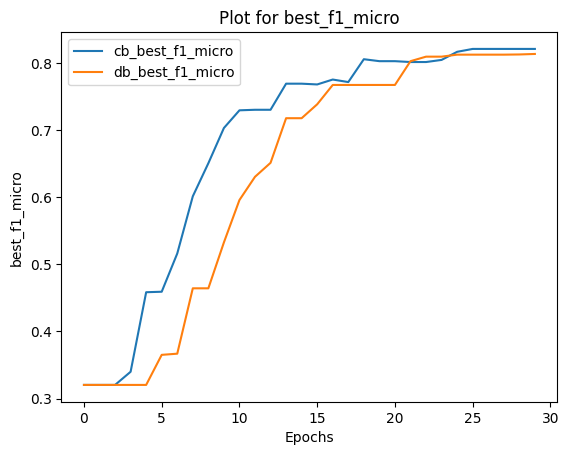

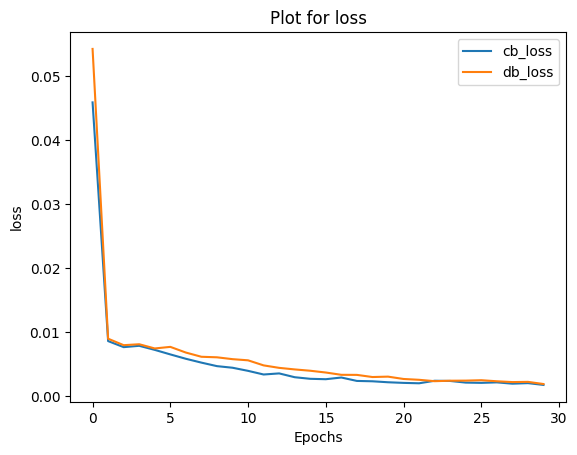

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

val_keys = set(val_key for item in history for val_key in history[item])
exclude_patterns = ['_th']
val_keys_filtered = [key for key in val_keys if not any(pattern in key for pattern in exclude_patterns)]


for val_key in val_keys_filtered:
    columns_to_plot = [col for col in df.columns if val_key in col]
    
    df[columns_to_plot].plot(kind='line')
    plt.title(f"Plot for {val_key}")
    plt.xlabel('Epochs')
    plt.ylabel(val_key)
    plt.legend(columns_to_plot)
    plt.show()